In [2]:
import pandas as pd
import numpy as np
import math
from sympy import *
import matplotlib.pyplot as plt
%matplotlib inline 
from numpy import log as ln
from scipy.stats import expon
from scipy.optimize import curve_fit
import array as arr

from scipy.optimize import minimize_scalar
from scipy.integrate import quad
from scipy import integrate


In [3]:
def arccot(x):
    return np.arctan(1/x)


Mp=0.13957
Mr=0.7736
Mk=0.496
Mh=0.54751


In [4]:
sdata1 = []
ps_sdata = []

with open('phase_pipi_1.dat', 'r') as file:
    lines = file.readlines()
    for line in lines:
        values = line.strip().split('\t')  # Split the line into values using tab as delimiter
        if len(values) >= 2:
            sdata1.append(float(values[0]))
            
            
sdata2= np.array(sdata1)
sdata=sdata2*(Mp**2)

### Low Phase Shift-1 (4* Mπ^2<=s<=0.6)

In [5]:
B0=1.043
B1=0.19
s0=1.05**2

def k(s):
    return np.sqrt((s/4)- Mp**2)

def w(s):
    return (np.sqrt(s)-np.sqrt(s0-s))/(np.sqrt(s)+ np.sqrt(s0-s))

def dlow1(s):
    return arccot((np.sqrt(s)*(Mr**2-s)*(B0+ B1*w(s)+ (2* Mp**3)/(np.sqrt(s)* Mr**2)))/ (2* (k(s)**3)) )


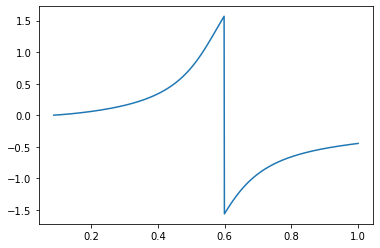

In [6]:
x1 = np.linspace(4*Mp**2+0.01, 1, 1000)
y1 = dlow1(x1)
plt.plot(x1, y1)
plt.show()



In [7]:
def func(x):
    return dlow1(x)  # Replace this with your actual function

def find_negative_crossing(func, lower_bound, upper_bound, epsilon=1e-6):
    if func(lower_bound) * func(upper_bound) > 0:
        return None  # No root exists in the specified range
    
    while abs(upper_bound - lower_bound) > epsilon:
        mid_point = (lower_bound + upper_bound) / 2
        if func(mid_point) < 0:
            upper_bound = mid_point
        else:
            lower_bound = mid_point
    
    return lower_bound

# Specify the range in which you want to search for the negative crossing
lower_bound = 0.59
upper_bound = 0.6

negative_crossing = find_negative_crossing(func, lower_bound, upper_bound)

if negative_crossing is not None:
    print(f"The function becomes negative around x = {negative_crossing:.6f}")
else:
    print("No negative crossing found in the specified range.")

The function becomes negative around x = 0.598456


### Low Phase Shift-2 (0.6<=s<=4* Μκ^2)

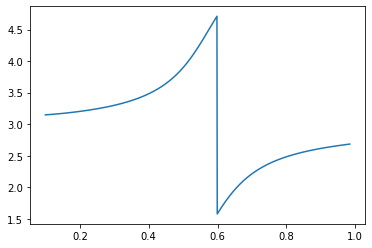

In [8]:
def dlow2(s):
    return dlow1(s)+ np.pi

x2 = np.linspace(0.1, 4* Mk**2, 1000)
y2 = dlow2(x2)
plt.plot(x2, y2)
plt.show()

### Medium Phase shift (4Mk^2<=s<= (1.3GeV)^2)

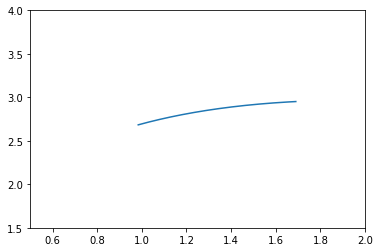

In [9]:
λ0=dlow2(4* Mk**2)
λ1=1.39
λ2=-1.7

def dmed(s):
    return λ0 + λ1* (np.sqrt(s)/(2*Mk) -1) + λ2*(np.sqrt(s)/(2*Mk) -1)**2


x3 = np.linspace(4*Mk**2, 1.3**2, 1000)


y3 = dmed(x3)
plt.plot(x3, y3)

plt.xlim([0.5,2])
plt.ylim([1.5,4])
plt.show()

### High Phase shift ((1.3)^2>=s)

In [10]:
s1=1.3**2

epsilon = 1e-6
# Calculate the derivative using finite differences
def dmed_der(s):
    return (dmed(s + epsilon) - dmed(s)) / epsilon

Ddmed= dmed_der(s1)

print("Derivative:",s1 , Ddmed)

Derivative: 1.6900000000000002 0.12963482065586618


In [11]:
s1=1.3**2
CA=(dmed(s1)-np.pi)/(Ddmed) +s1
CB=(np.pi-dmed(s1))*(CA-s1)

def dhigh(s):
    return np.pi-(CB/(CA-s))


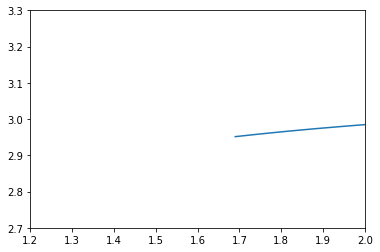

In [12]:
x4 = np.linspace(1.3**2, 2, 1000)
y4 = dhigh(x4)
plt.plot(x4, y4)

plt.xlim([1.2, 2])
plt.ylim([2.7, 3.3])
plt.show()



### Definition and Graph of  δ(s)

In [13]:
def δ(x):
    return np.piecewise(x, [(x>=4* Mp**2) & ( x <= 0.598456), (0.598456 < x) & (x <= 4* Mk**2), (x>= 4* Mk**2) & (x<= 1.3**2), x>=1.3**2 ], [lambda x: dlow1(x), lambda x: dlow2(x), lambda x: dmed(x) , lambda x: dhigh(x) ])

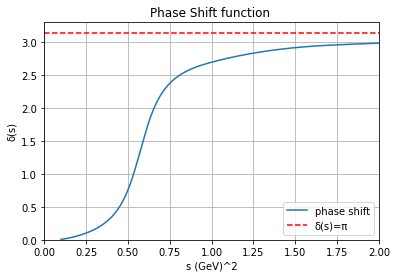

In [14]:
s = np.linspace(0.1, 2, 1000)
y = δ(s)
plt.plot(s, y, label='phase shift')

plt.xlim([0, 2])
plt.ylim([0, 3.3])

plt.xlabel('s (GeV)^2')
plt.ylabel('δ(s)')
plt.title('Phase Shift function ')
plt.axhline(y=np.pi, color='red', linestyle='--', label='δ(s)=π')
plt.legend()
plt.grid(True)

#plt.savefig('MadridPhaseShift.png',bbox_inches ="tight",pad_inches = 1,transparent = True,facecolor ="w",edgecolor ='w',dpi=150)

plt.show()

## Numerical Calculation of Ω(s)

In [15]:
def integrand(x, s):
    return (δ(x) - δ(s)) / (x * (x - s))


def principal_value_integral(s):
    lower_limit = 4 * Mp**2  

    def integrand_positive(x, s):
        return integrand(x, s)

    def integrand_negative(x, s):
        return integrand(x, s)

    result_pos, _ = quad(integrand_positive, lower_limit, s, args=(s,))
    result_neg, _ = quad(integrand_negative, s, np.inf, args=(s,))

    return result_pos + result_neg


PVresults = []

for i in s:
    result = principal_value_integral(i)
    PVresults.append(result)




In [16]:
Omega=[]

Omega=np.exp( ((s*PVresults)/ np.pi) + δ(s)*1j  - np.log((s- 4* Mp**2)/(4*Mp**2))*δ(s)/np.pi   )

ReOmega= Omega.real
ImOmega = Omega.imag
AbsOmega = abs(Omega)


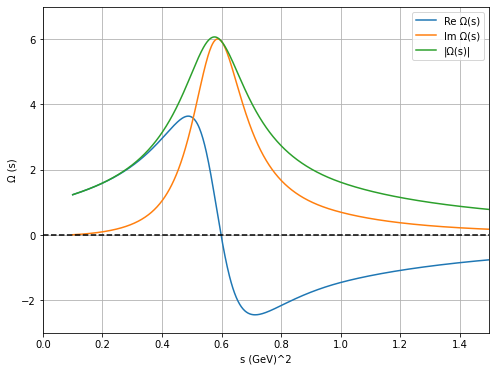

In [17]:
plt.figure(figsize=(8, 6)) 


plt.plot(s, ReOmega, label='Re Ω(s)')
plt.plot(s, ImOmega, label='Im Ω(s)')
plt.plot(s, AbsOmega, label='|Ω(s)|')

plt.axhline(y=0, color='black', linestyle='--')
plt.xlim([0, 1.5])
plt.ylim([-3, 7])

plt.xlabel('s (GeV)^2')
plt.ylabel('Ω (s)')
plt.legend()
plt.grid(True)

plt.savefig('MadridOmnesFunc.png',bbox_inches ="tight",pad_inches = 1,transparent = True,facecolor ="w",edgecolor ='w',dpi=150)


plt.show()

### Test of the Bern data for phase shift

In [ ]:
PVdataresults = []

for i in sdata:
    result = principal_value_integral(i)
    PVdataresults.append(result)


OmegaData=[]

OmegaData=np.exp( ((sdata*PVdataresults)/ np.pi) + δ(sdata)*1j  - np.log((sdata- 4* Mp**2)/(4*Mp**2))*δ(sdata)/np.pi   )

ReOmegaData= OmegaData.real
ImOmegaData = OmegaData.imag
AbsOmegaData = abs(OmegaData)

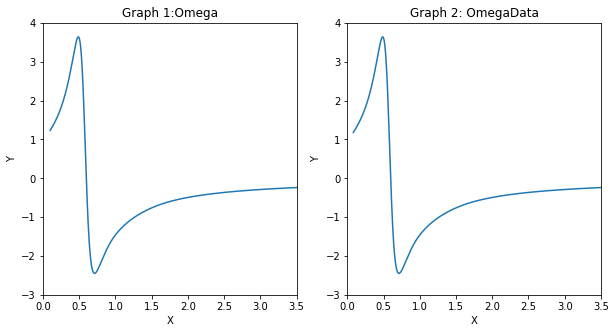

In [21]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(s, ReOmega, label='Re Ω(s)')
ax1.set_title('Graph 1:Omega')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(0, 3.5)  
ax1.set_ylim(-3, 4)  


# Plot the second graph on the second subplot
ax2.plot(sdata, ReOmegaData, label='Re Ω(s)data')
ax2.set_title('Graph 2: OmegaData')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_xlim(0, 3.5)  
ax2.set_ylim(-3, 4) 



plt.show()